In [94]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("akashdeepkuila/big-mart-sales")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/big-mart-sales


In [95]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error


In [96]:
train_df = pd.read_csv('/root/.cache/kagglehub/datasets/akashdeepkuila/big-mart-sales/versions/1/Train-Set.csv')
test_df = pd.read_csv('/root/.cache/kagglehub/datasets/akashdeepkuila/big-mart-sales/versions/1/Test-Set.csv')


In [97]:
train_df.head()

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,OutletSales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [98]:
test_df.head()

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [99]:
train_df.shape,test_df.shape

((8523, 12), (5681, 11))

In [100]:
train_df['source'] = 'train'
test_df['source'] = 'test'
test_df['OutletSales'] = None


In [101]:
data = pd.concat([train_df, test_df], ignore_index=True)
data.head()

/tmp/ipython-input-101-4184145296.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([train_df, test_df], ignore_index=True)


,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,OutletSales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [102]:
data.isnull().sum()

,0
ProductID,0
Weight,2439
FatContent,0
ProductVisibility,0
ProductType,0
MRP,0
OutletID,0
EstablishmentYear,0
OutletSize,4016
LocationType,0


In [103]:
data['Weight'] = data.groupby('ProductID')['Weight'].transform(lambda x: x.fillna(x.mean()))
data['OutletSize'] = data.groupby('OutletType')['OutletSize'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
data.isnull().sum()

,0
ProductID,0
Weight,0
FatContent,0
ProductVisibility,0
ProductType,0
MRP,0
OutletID,0
EstablishmentYear,0
OutletSize,0
LocationType,0


In [104]:
data['FatContent'].value_counts()

,count
FatContent,
Low Fat,8485
Regular,4824
LF,522
reg,195
low fat,178


In [105]:
data['FatContent'] = data['FatContent'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'})
data['FatContent'].value_counts()

,count
FatContent,
Low Fat,9185
Regular,5019


In [106]:
data['OutletAge'] = 2025 - data['EstablishmentYear']
data=data.drop('EstablishmentYear', axis=1)


In [107]:
le = LabelEncoder()
label_cols = ['FatContent', 'OutletID', 'OutletSize', 'LocationType', 'OutletType', 'ProductType']
for col in label_cols:
    data[col] = le.fit_transform(data[col])


In [108]:
data.head()

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,OutletSize,LocationType,OutletType,OutletSales,source,OutletAge
0,FDA15,9.30,0,0.016047,4,249.8092,9,1,0,1,3735.1380,train,26
1,DRC01,5.92,1,0.019278,14,48.2692,3,1,2,2,443.4228,train,16
2,FDN15,17.50,0,0.016760,10,141.6180,9,1,0,1,2097.2700,train,26
3,FDX07,19.20,1,0.000000,6,182.0950,0,2,2,0,732.3800,train,27
4,NCD19,8.93,0,0.000000,9,53.8614,1,0,2,1,994.7052,train,38


In [109]:
train = data[data['source'] == 'train'].copy()
test = data[data['source'] == 'test'].copy()

train.drop(['source','ProductID'], axis=1, inplace=True)
test.drop(['source', 'OutletSales','ProductID'], axis=1, inplace=True)

In [110]:
train.head()

,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,OutletSize,LocationType,OutletType,OutletSales,OutletAge
0,9.30,0,0.016047,4,249.8092,9,1,0,1,3735.1380,26
1,5.92,1,0.019278,14,48.2692,3,1,2,2,443.4228,16
2,17.50,0,0.016760,10,141.6180,9,1,0,1,2097.2700,26
3,19.20,1,0.000000,6,182.0950,0,2,2,0,732.3800,27
4,8.93,0,0.000000,9,53.8614,1,0,2,1,994.7052,38


In [111]:
test.head()

,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,OutletSize,LocationType,OutletType,OutletAge
8523,20.750,0,0.007565,13,107.8622,9,1,0,1,26
8524,8.300,1,0.038428,4,87.3198,2,2,1,1,18
8525,14.600,0,0.099575,11,241.7538,0,2,2,0,27
8526,7.315,0,0.015388,13,155.0340,2,2,1,1,18
8527,13.600,1,0.118599,4,234.2300,5,1,2,3,40


In [112]:
X = train.drop('OutletSales', axis=1)
y = train['OutletSales']


In [113]:
print(X,y)

      Weight  FatContent  ...  OutletType  OutletAge
0      9.300           0  ...           1         26
1      5.920           1  ...           2         16
2     17.500           0  ...           1         26
3     19.200           1  ...           0         27
4      8.930           0  ...           1         38
...      ...         ...  ...         ...        ...
8518   6.865           0  ...           1         38
8519   8.380           1  ...           1         23
8520  10.600           0  ...           1         21
8521   7.210           1  ...           2         16
8522  14.800           0  ...           1         28

[8523 rows x 10 columns] 0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: OutletSales, Length: 8523, dtype: float64


In [114]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [120]:
models = [RandomForestRegressor(), XGBRegressor(), DecisionTreeRegressor()]

def compare_models(X_train, X_val, y_train, y_val, test_data):
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Evaluation
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        print(f"{model.__class__.__name__}:\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")
        print('-' * 80)

        # Plotting
        plt.scatter(y_val, y_pred, color='b')
        plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f"{model.__class__.__name__} Actual vs Predicted")
        plt.grid()
        plt.show()
        print('-----------' * 80)

        # Test set predictions
        test_preds = model.predict(test_data)
        print(f"Test predictions (first 10):\n{test_preds[:10]}")


RandomForestRegressor:
RMSE: 1088.40, MAE: 757.46, R²: 0.5642
--------------------------------------------------------------------------------


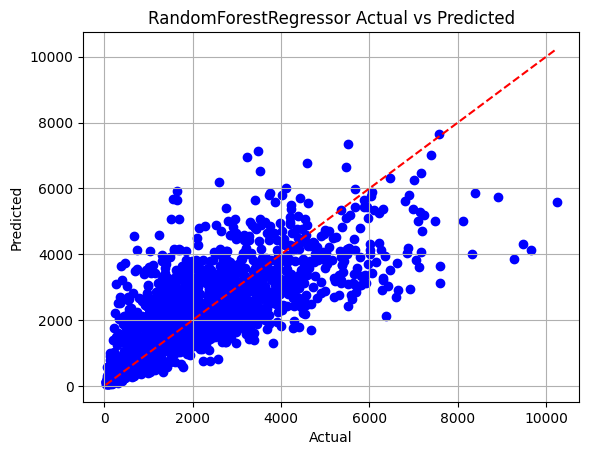

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test predictions (first 10):
[1671.42432  1213.959798  530.489466 2572.032006 6475.717276 1949.269318
  660.586786 2011

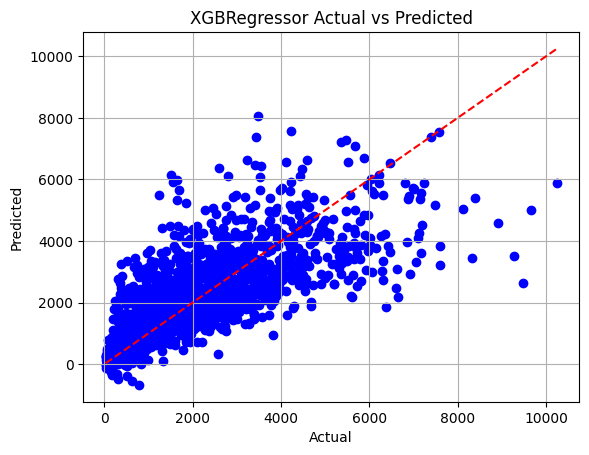

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test predictions (first 10):
[1467.3906 1128.9587  615.2032 2650.0464 7519.072  1723.2751  568.706
 2297.2244 1047.5707

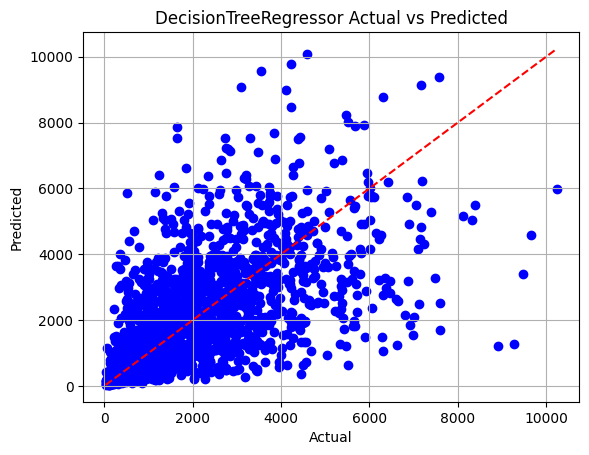

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test predictions (first 10):
[2787.0388 1731.08    484.7024 4287.752  6024.1584 2756.412   623.1888
 1331.6     661.805

In [121]:
compare_models(X_train, X_val, y_train, y_val, test)

#**I'm going to try and do hyperparameter tuning on RandomForestRegressor and XGBRegressor to see if I can improve their current performance.**

##RandomforestRegressor

In [128]:
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')


In [129]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}



In [130]:
rf_model = RandomForestRegressor(random_state=42)

rf_random = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_params,
    n_iter=10,               #this is the number of combinations to try
    cv=3,                    # use 3-fold cross-validation
    verbose=1,
    scoring='r2',
    n_jobs=-1,               # use all CPU cores
    random_state=42
)

rf_random.fit(X_train, y_train)

print("Best Parameters for Random Forest:", rf_random.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30}


In [131]:
best_rf = rf_random.best_estimator_
rf_pred = best_rf.predict(X_val)

rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
rf_mae = mean_absolute_error(y_val, rf_pred)
rf_r2 = r2_score(y_val, rf_pred)

print(f"Tuned RandomForest:\nRMSE: {rf_rmse:.2f}, MAE: {rf_mae:.2f}, R²: {rf_r2:.4f}")


Tuned RandomForest:
RMSE: 1031.79, MAE: 720.57, R²: 0.6083


#XGBRegressor

In [132]:
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}


In [135]:
xgb_model = XGBRegressor(random_state=42)

xgb_random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_params,
    n_iter=10,
    cv=3,
    verbose=1,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

xgb_random.fit(X_train, y_train)

print("Best Parameters for XGBoost:", xgb_random.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [136]:
best_xgb = xgb_random.best_estimator_
xgb_pred = best_xgb.predict(X_val)

xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
xgb_mae = mean_absolute_error(y_val, xgb_pred)
xgb_r2 = r2_score(y_val, xgb_pred)

print(f"Tuned XGBoost:\nRMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}, R²: {xgb_r2:.4f}")


Tuned XGBoost:
RMSE: 1034.94, MAE: 726.79, R²: 0.6059


#Finished🚀🚀🚀🚀